In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment2/'
FOLDERNAME = 'cs6353/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/My Drive/cs6353/assignments/assignment2/cs6353/datasets
--2024-12-06 06:04:50--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  33.9MB/s    in 5.1s    

2024-12-06 06:04:56 (31.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/cs6353/assignments/assignment2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs6353/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs6353/classifiers/softmax.py**.


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs6353/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs6353.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.345899
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

We expect the loss to be close to -log(0.1) because of the way the softmax loss function is designed and the initial conditions of our classifier.

  1. Understanding the Softmax Function:

    * The softmax classifier outputs probabilities for each class by normalizing the raw scores (logits) using the exponential function. These probabilities are always between 0 and 1 and sum up to 1 across all classes.

    * The loss for a single data point is -log(py),is the probability assigned to the correct class by the model.

  2. Random Initialization of Weights:

    * When we initialize the weight matrix 𝑊 with small random values, the raw scores (logits) for each class are also small and nearly equal for all classes. This happens because no specific class has been favored yet.

    * As a result, the softmax probabilities for all classes become roughly equal. For 𝐶 classes, this means each class has a probability of approximately 1/𝐶.

  3. Loss with Uniform Probabilities:

    * For the CIFAR-10 dataset, we have 10 classes (𝐶 = 10),so each class has an equal probability of 0.1 under these conditions.

    * Substituting 𝑝𝑦 = 0.1 into the loss formula −log(𝑝𝑦), we get −log(0.1) ≈ 2.302585.

    * Therefore, we expect the average loss to be close to this value at the start.


  4. Why It's Not Exactly −log(0.1):

    * The actual loss might deviate slightly because:

      * The weight initialization, while random, is not perfectly symmetric.

      * The dataset might not have perfectly uniform distributions of classes in the sampled minibatch.

Thus, At initialization, the model assigns roughly equal probabilities to all classes because the weights are randomly initialized and there’s no meaningful structure in the predictions yet. This leads to a softmax loss that approximates −log(1/𝐶), which in this case is −log(0.1) ≈ 2.302585.








In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs6353.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.611529 analytic: 0.611529, relative error: 9.919252e-08
numerical: 0.206527 analytic: 0.206527, relative error: 3.416237e-07
numerical: -0.563526 analytic: -0.563526, relative error: 3.992586e-08
numerical: 0.009354 analytic: 0.009354, relative error: 2.546502e-06
numerical: -2.865454 analytic: -2.865454, relative error: 6.129823e-11
numerical: -0.676505 analytic: -0.676505, relative error: 5.979998e-08
numerical: 0.250689 analytic: 0.250689, relative error: 3.165685e-08
numerical: 1.846244 analytic: 1.846244, relative error: 9.072495e-09
numerical: 1.024461 analytic: 1.024460, relative error: 1.066768e-07
numerical: 0.115710 analytic: 0.115710, relative error: 7.134728e-07
numerical: 0.339765 analytic: 0.339765, relative error: 5.692639e-08
numerical: -1.204218 analytic: -1.204218, relative error: 2.061541e-08
numerical: 0.748070 analytic: 0.748070, relative error: 3.931086e-08
numerical: -2.090191 analytic: -2.090191, relative error: 1.105953e-09
numerical: -2.541641 ana

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs6353.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.345899e+00 computed in 0.113384s
vectorized loss: 2.345899e+00 computed in 0.032297s
Loss difference: 0.000000
Gradient difference: 0.000000


lr 1.000000e-08 reg 2.000000e+04 train accuracy: 0.222 val accuracy: 0.231
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.236 val accuracy: 0.265
lr 1.000000e-08 reg 3.000000e+04 train accuracy: 0.263 val accuracy: 0.281
lr 1.000000e-08 reg 4.000000e+04 train accuracy: 0.288 val accuracy: 0.300
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.297 val accuracy: 0.319
lr 5.000000e-08 reg 2.000000e+04 train accuracy: 0.339 val accuracy: 0.349
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.331 val accuracy: 0.350
lr 5.000000e-08 reg 3.000000e+04 train accuracy: 0.321 val accuracy: 0.336
lr 5.000000e-08 reg 4.000000e+04 train accuracy: 0.318 val accuracy: 0.327
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.304 val accuracy: 0.316
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.340 val accuracy: 0.353
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.327 val accuracy: 0.341
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.322 val accuracy: 0.340
lr 1.000000e-07 reg 4.000

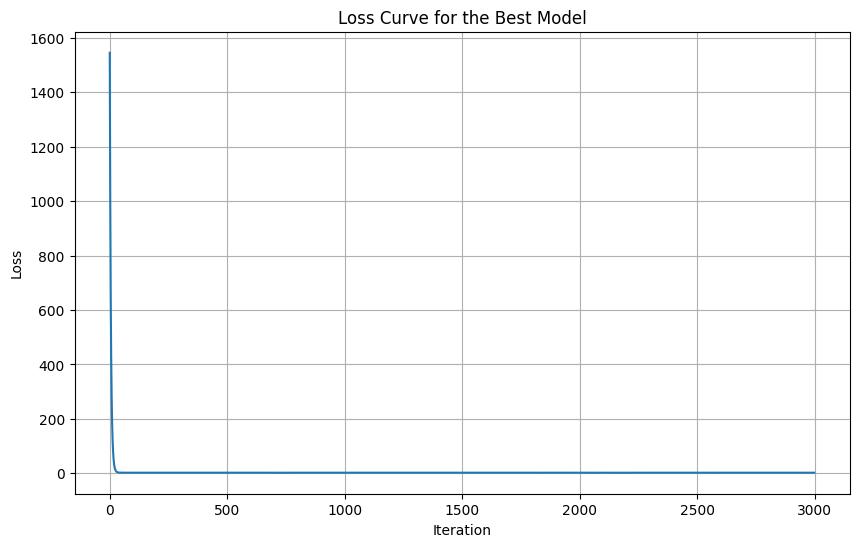

Final test set accuracy: 0.352


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs6353.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [2e4, 2.5e4, 3e4, 4e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifier in best_softmax.                         #
################################################################################

# Number of iterations for training
num_iters = 3000

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        # Train the softmax classifier
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=num_iters, verbose=False)

        # Evaluate training accuracy
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train_pred == y_train)

        # Evaluate validation accuracy
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val_pred == y_val)

        # Store results
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Update the best model
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax



################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in results:
    train_accuracy, val_accuracy = results[(lr, reg)]
    print(f'lr {lr:e} reg {reg:e} train accuracy: {train_accuracy:.3f} val accuracy: {val_accuracy:.3f}')

print(f'Best validation accuracy achieved: {best_val:.3f}')

# Visualize the loss trends for the best model
plt.figure(figsize=(10, 6))
plt.plot(loss_hist)
plt.title('Loss Curve for the Best Model')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate the best model on the test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Final test set accuracy: {test_accuracy:.3f}')

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.352000


**Inline Question** - *True or False*

It's possible to add a new data point to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer:* The statement is true

*Your explanation*:

The Structured SVM (Support Vector Machine) loss is based on the concept of margins. It encourages the correct class to have a score that is higher than the scores of all other classes by a margin of at least 1 (or a delta value).

  * For any given data point, if the difference between the correct class score and the incorrect class scores satisfies the margin condition, then the loss for that data point is zero, and it does not contribute to the overall loss.

  * Adding a new data point to the training set that already satisfies the margin condition will not change the SVM loss. Such a point is considered "non-supporting" because it lies far from the decision boundary and does not influence the model. This is why SVM is considered sparse—only a subset of data points (support vectors) directly affects the model.



The Softmax classifier works differently. The Softmax loss encourages the correct class to have a higher score than all other classes, but instead of relying on a margin, it computes the probability of each class using the softmax function.

  * For the Softmax loss, every data point contributes to the overall loss, regardless of how confidently it is classified. Even if a data point is correctly classified with high confidence,
  is very close to 1, it still contributes a small, non-zero loss value.

  * Adding a new data point to the training set will always affect the Softmax loss because the loss depends on the probabilities, which in turn depend on all the scores. Even if the model is already confident in its predictions, the presence of an additional data point will still influence the gradient update and change the overall loss slightly.



Thus, statement is true because for the SVM loss, it is possible to add a data point that does not affect the loss if it is correctly classified with a sufficient margin. However, for the Softmax loss, every data point affects the loss, even if it is correctly classified with high confidence, due to the way probabilities are computed and contribute to the overall loss.



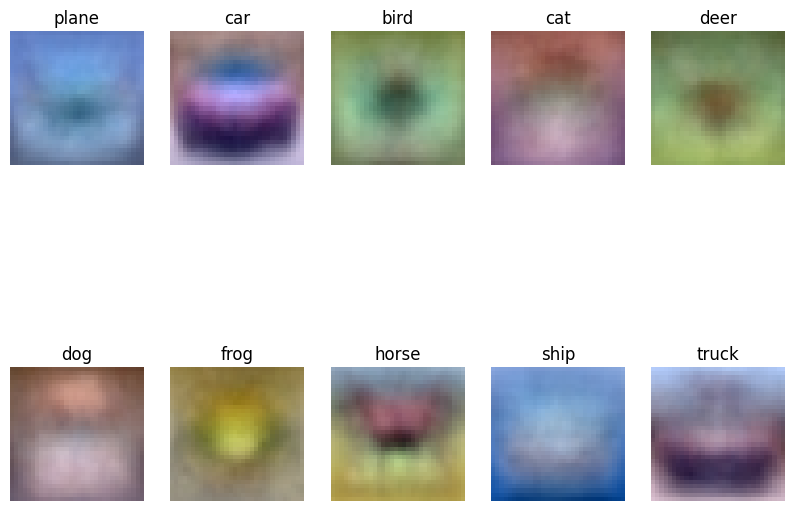

In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])